* `import libraries`

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette= "Set2")
import os
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif, chi2 ## ANOVA & Chi-Square
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

* `read dataset`

In [4]:
DATA_PATH = os.path.join(os.getcwd(),"..", "dataset", "churn_modelling.csv")
df = pd.read_csv(DATA_PATH)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# adjust columns names
df.columns = df.columns.str.strip().str.replace(" ", "_")


In [6]:
# drop first 3 columns
df.drop(df.columns[:3], axis=1, inplace = True)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [8]:
df.describe()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


* `EDA`

In [9]:
# check for missing values
df.isnull().sum()


CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
# Geography
df["Geography"].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [11]:
# Gender
df["Gender"].value_counts()


Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [12]:
# Target
df["Exited"].value_counts(normalize=True)


Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

In [13]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [14]:
df["Tenure"].unique()


array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0], dtype=int64)

## `Data VIZ & Handling Outliers`

* `univariate visualization`

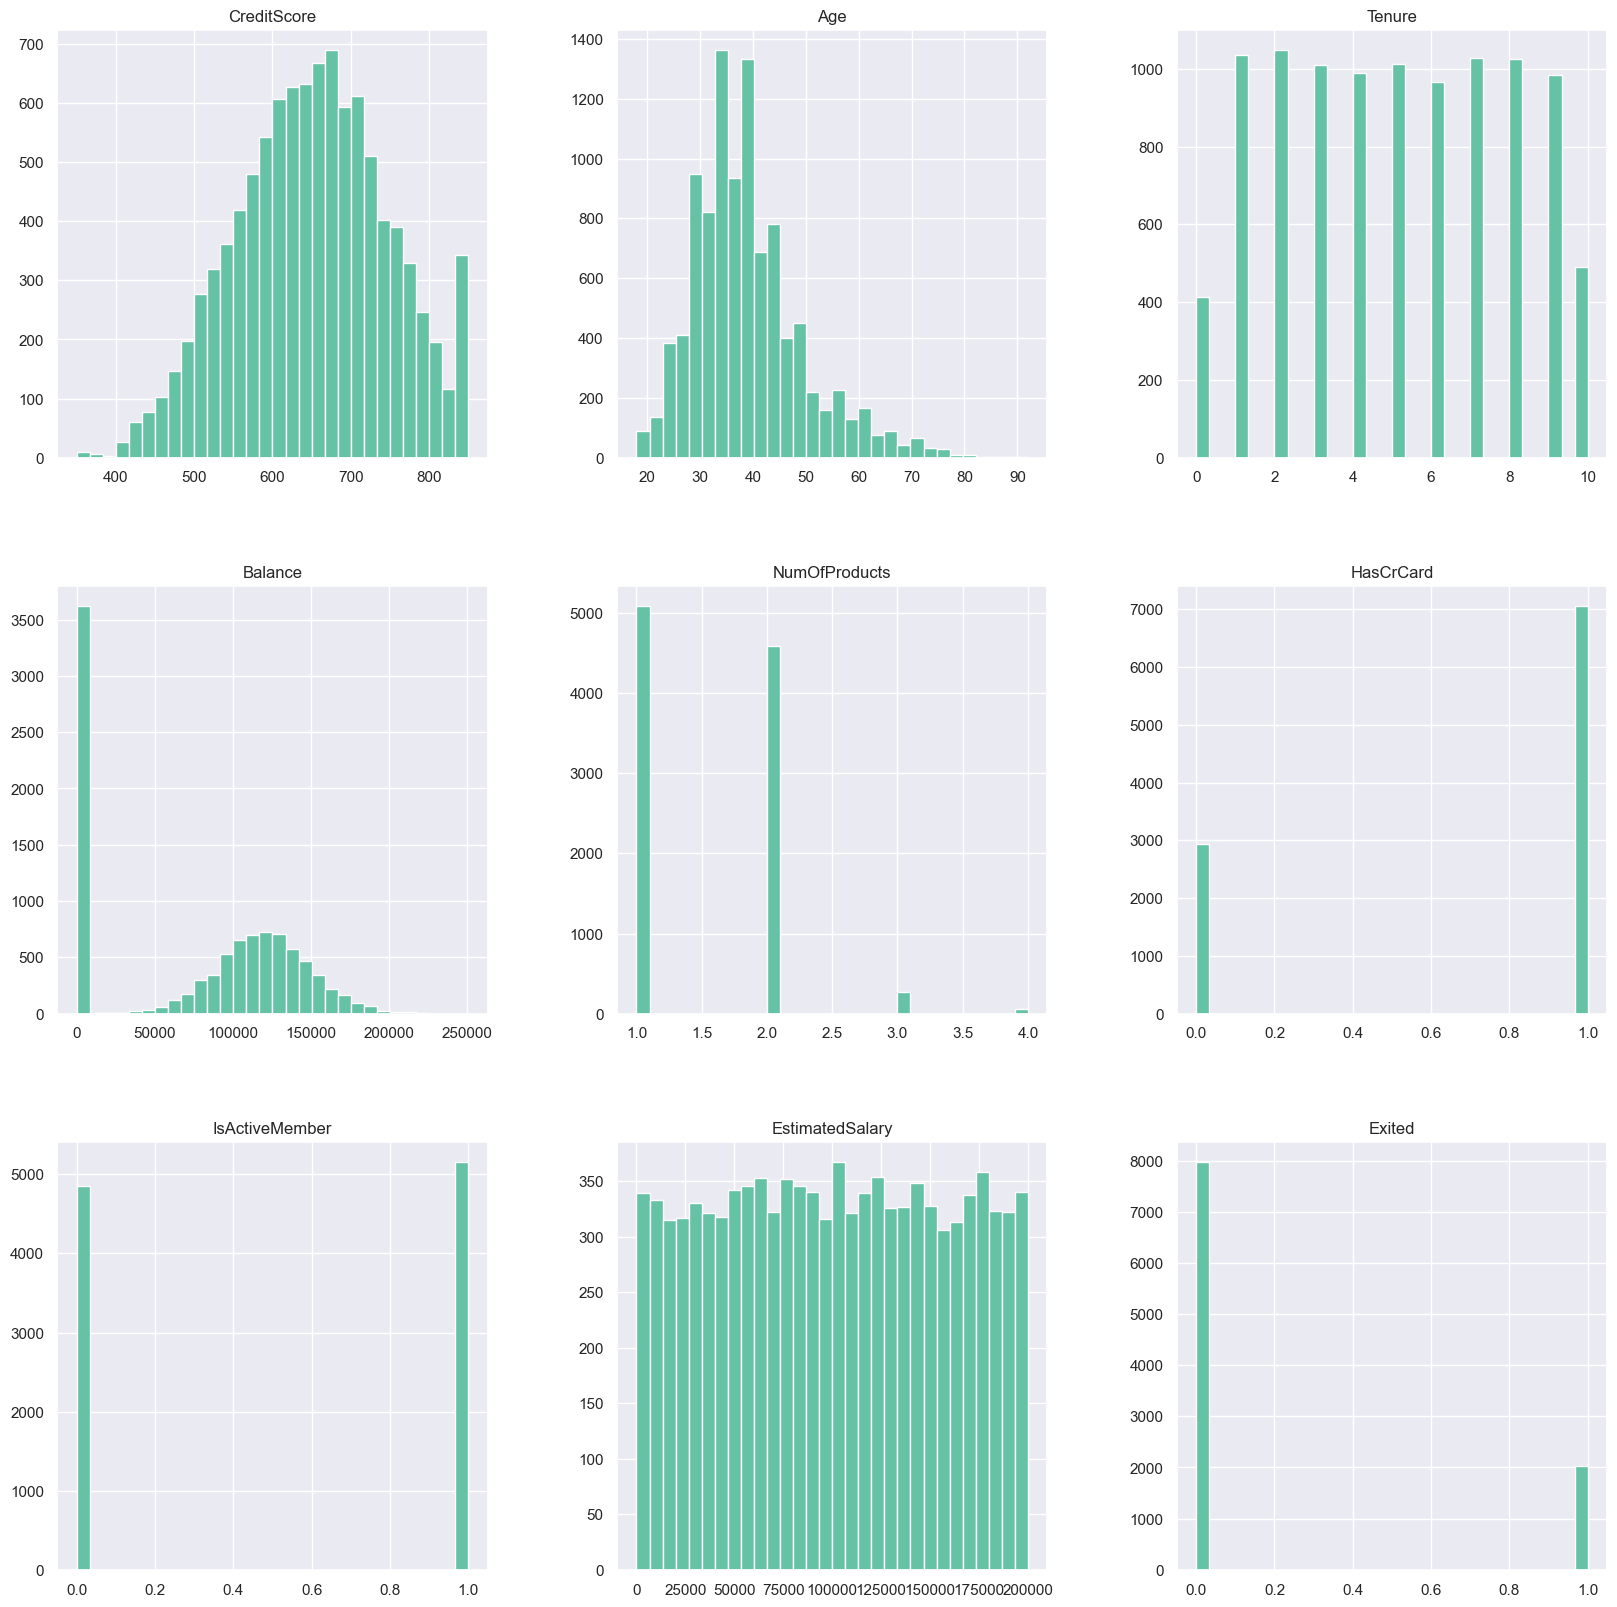

In [15]:
## numerical features
df.hist(bins=30, figsize=(20,20), layout= (3,3) )
plt.show()


In [16]:
df.drop(df[df["Age"] > 80].index.tolist(), axis=0, inplace=True)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


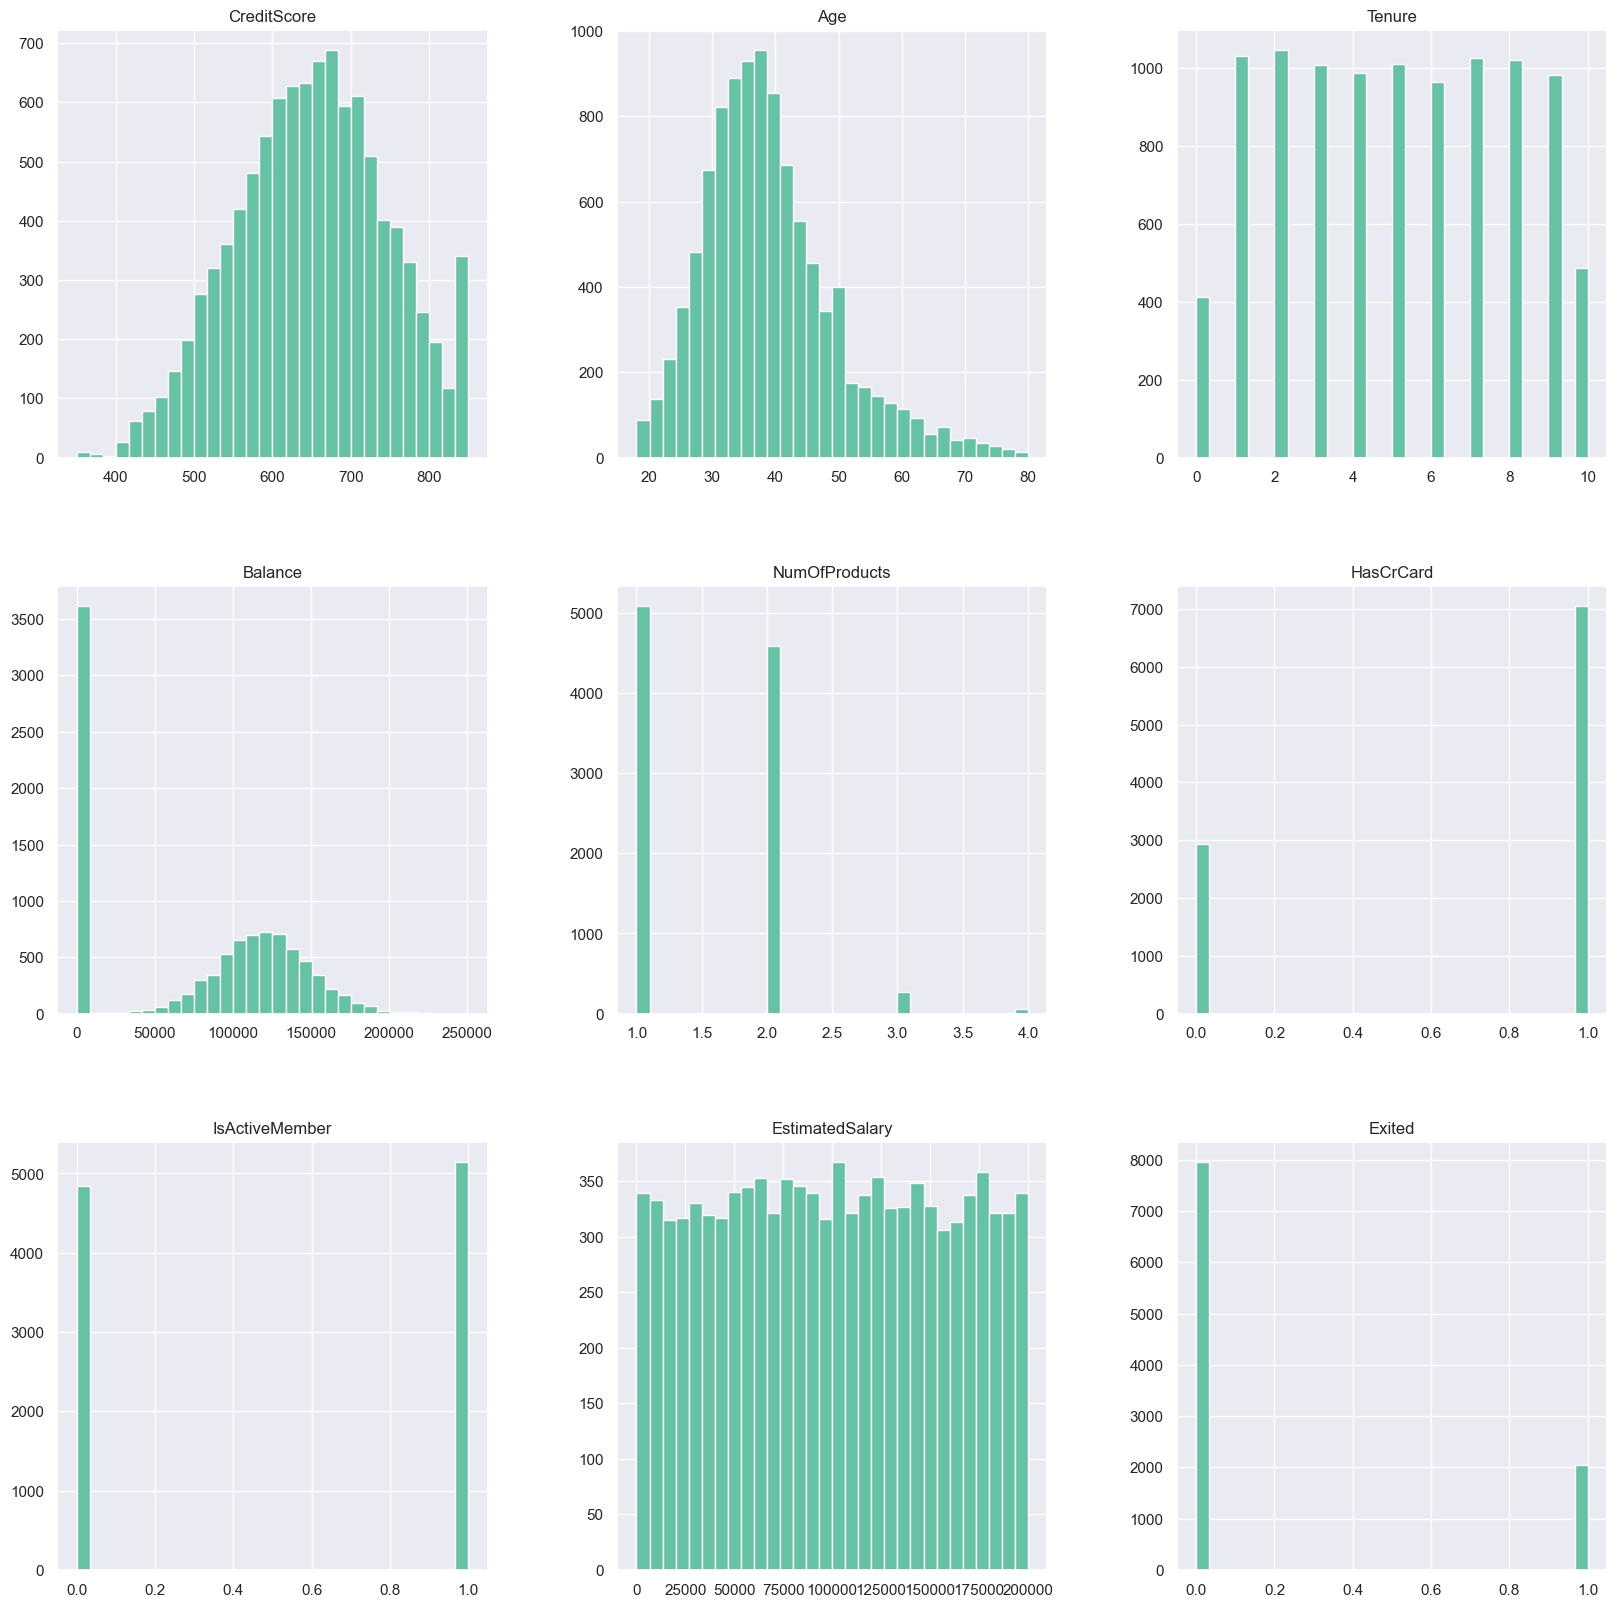

In [17]:
## numerical features
df.hist(bins=30, figsize=(20,20), layout= (3,3) )
plt.show()

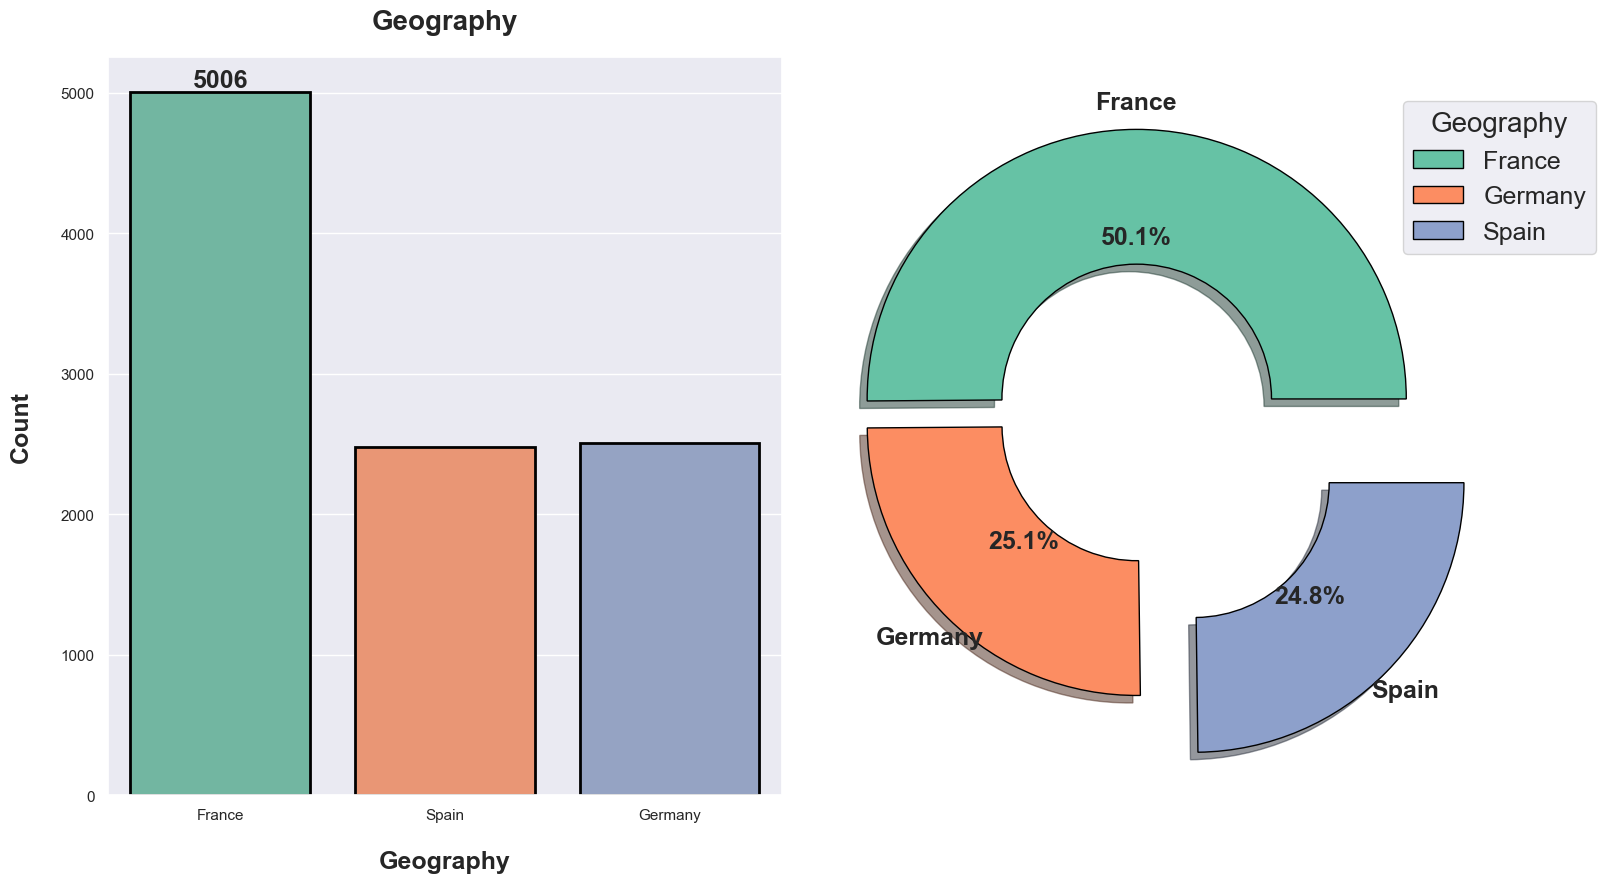

In [18]:
## countplot
fig, ax= plt.subplots(1, 2, figsize= (16,9), tight_layout= True)
ax[0]= sns.countplot(data= df, x= "Geography", palette= "Set2", ax= ax[0], edgecolor= "black", linewidth= 2)
ax[0].bar_label(ax[0].containers[0], fontsize= 18, weight= "bold")
ax[0].set_title("Geography", fontsize= 20, weight= "bold", pad= 20)
ax[0].set_xlabel("Geography", fontsize= 18, weight= "bold", labelpad= 20)
ax[0].set_ylabel("Count", fontsize= 18, weight= "bold", labelpad= 20)

## pie chart
ax[1]= plt.pie(df["Geography"].value_counts(), labels= df["Geography"].value_counts().index, autopct= "%1.1f%%",
                colors= sns.color_palette("Set2", 3), explode= (0.1, 0, 0.3), shadow= True,
                wedgeprops= dict(width= 0.5, edgecolor= "black"), 
                textprops= dict(fontsize= 18, weight= "bold", ha= "center"))
plt.legend(df["Geography"].value_counts().index, title= "Geography", fontsize= 18, 
           title_fontsize= 20, loc= "upper right", bbox_to_anchor= (1.2, 1.0))



plt.show()

<Axes: xlabel='EstimatedSalary'>

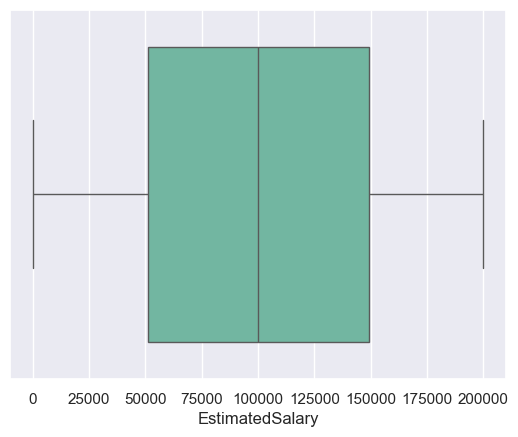

In [19]:
## boxplot for EstimatedSalary
sns.boxplot(data= df, x= "EstimatedSalary", palette= "Set2")

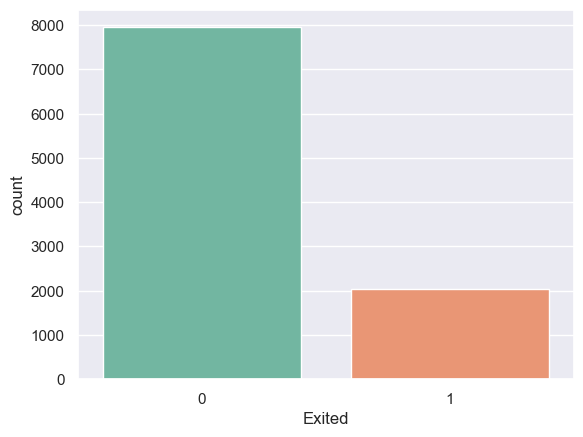

In [20]:
## countplot for Exited
sns.countplot(data= df, x= "Exited", palette= "Set2")
plt.show()

* `bivariate visualization`

Gender
Female    100575.998277
Male       99671.901194
Name: EstimatedSalary, dtype: float64


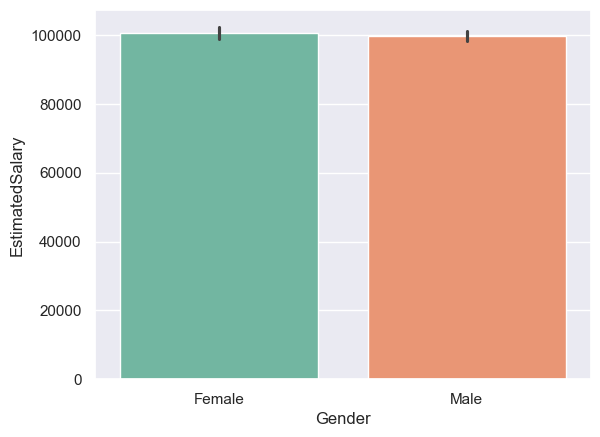

In [21]:
## Average EstimatedSalary by Gender
print(df[["Gender", "EstimatedSalary"]].groupby("Gender")["EstimatedSalary"].mean())
sns.barplot(data= df, x= "Gender", y= "EstimatedSalary", palette= "Set2", estimator= "mean")
plt.show()


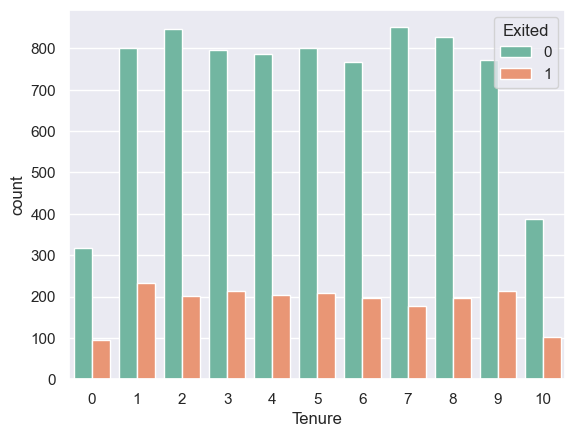

In [22]:
## relation between tenure and Exited
sns.countplot(data= df, x= "Tenure", hue= "Exited", palette= "Set2")
plt.show()

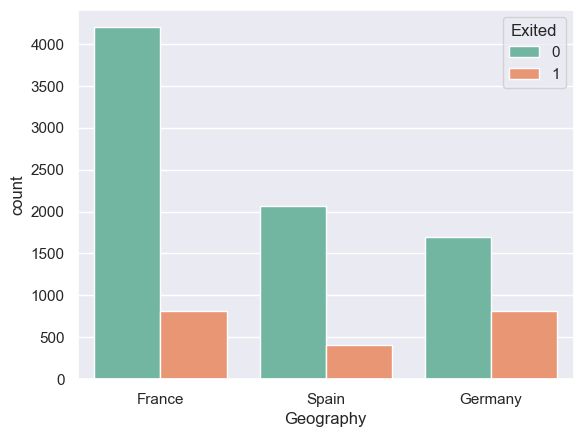

In [23]:
## geography and Exited
sns.countplot(data= df, x= "Geography", hue= "Exited")
plt.show()

## `split to train & test`

In [24]:
## to features & target
X = df.drop("Exited", axis= 1)
y = df["Exited"]

In [25]:
## split to train & test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42, shuffle= True, stratify= y)

## check shapes
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)


x_train shape:  (6991, 10)
x_test shape:  (2997, 10)
y_train shape:  (6991,)
y_test shape:  (2997,)


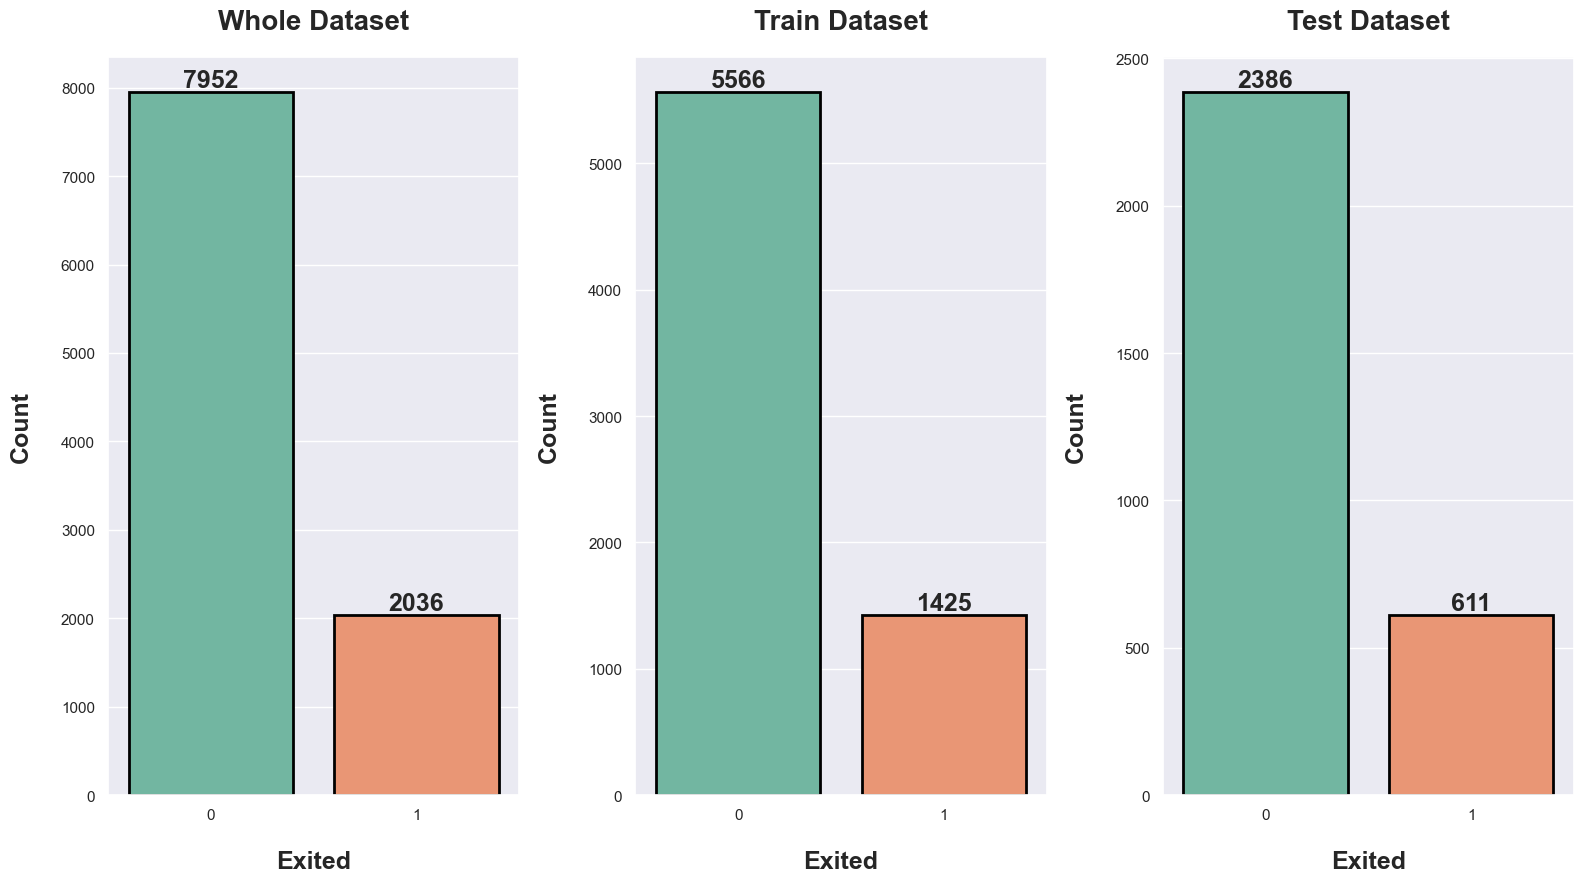

In [26]:
# Create the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(16, 9), tight_layout=True)

# Plot for the whole dataset
sns.countplot(x=y, edgecolor="black", linewidth=2, palette="Set2", ax=ax[0])
for container in ax[0].containers:
    ax[0].bar_label(container, fontsize=18, weight="bold")
ax[0].set_title("Whole Dataset", fontsize=20, weight="bold", pad=20)
ax[0].set_xlabel("Exited", fontsize=18, weight="bold", labelpad=20)
ax[0].set_ylabel("Count", fontsize=18, weight="bold", labelpad=20)

# Plot for the training dataset
sns.countplot(x=y_train, edgecolor="black", linewidth=2, palette="Set2", ax=ax[1])
for container in ax[1].containers:
    ax[1].bar_label(container, fontsize=18, weight="bold")
ax[1].set_title("Train Dataset", fontsize=20, weight="bold", pad=20)
ax[1].set_xlabel("Exited", fontsize=18, weight="bold", labelpad=20)
ax[1].set_ylabel("Count", fontsize=18, weight="bold", labelpad=20)

# Plot for the test dataset
sns.countplot(x=y_test, edgecolor="black", linewidth=2, palette="Set2", ax=ax[2])
for container in ax[2].containers:
    ax[2].bar_label(container, fontsize=18, weight="bold")
ax[2].set_title("Test Dataset", fontsize=20, weight="bold", pad=20)
ax[2].set_xlabel("Exited", fontsize=18, weight="bold", labelpad=20)
ax[2].set_ylabel("Count", fontsize=18, weight="bold", labelpad=20)

# Show the plot
plt.show()


## `Feature Selection & Preprocessing`

In [27]:
x_train.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [28]:
## slice cols
num_cols = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
cat_cols = ["Geography", "Gender"]
ready_cols = list(set(x_train.columns) - set(num_cols) - set(cat_cols))


In [29]:
## numerical cols & target --> ANOVA
_, p_values = f_classif(X= x_train[num_cols], y= y_train)
p_values
## All p-values are less than 0.05, so we can keep all numerical features

array([1.86057834e-002, 5.93314285e-133, 9.21735375e-026, 5.23232433e-001])

In [30]:
## categorical cols & target --> Chi-Square
ordinal_encoder = OrdinalEncoder()
_, p_values = chi2(X= ordinal_encoder.fit_transform(x_train[cat_cols]), y= y_train)
p_values
## All p-values are less than 0.05, so we can keep all categorical features

array([8.80359855e-03, 8.85368009e-09])

In [31]:
## ready cols & target --> Chi-Square
_, p_values = chi2(X= x_train[ready_cols], y= y_train)
p_values
## All p-values are less than 0.05, so we can keep all ready features


array([8.91277038e-20, 9.47100267e-01, 3.04853676e-01, 3.38438759e-02])

In [32]:
## pipline

## num_cols --> imputing with median & standardscaler
## cat_cols --> imputing with mode & OHE
## ready_cols --> imputing with mode

## for num_cols
num_pipeline = Pipeline(steps= [("imputer", SimpleImputer(strategy= "median")),
                                 ("scaler", StandardScaler())])

## for cat_cols
cat_pipeline = Pipeline(steps= [("imputer", SimpleImputer(strategy= "most_frequent")),
                                ("ohe", OneHotEncoder(sparse_output= False, drop= "first"))])

## for ready_cols
ready_pipeline = Pipeline(steps= [("imputer", SimpleImputer(strategy= "most_frequent"))])


## combine All

preprocessor = ColumnTransformer(transformers= [("numerical", num_pipeline, num_cols),
                                                ("categorical", cat_pipeline, cat_cols),
                                                ("ready", ready_pipeline, ready_cols)])

## apply to train & test
x_train_final = preprocessor.fit_transform(x_train)
x_test_final = preprocessor.transform(x_test)


In [33]:
## check train shapes
print("x_train_final shape: ", x_train_final.shape)
print("y_train shape: ", y_train.shape)


x_train_final shape:  (6991, 11)
y_train shape:  (6991,)


## `dealing with imbalanced data`

In [34]:
## 1. prepare weights to solve imbalanced data
vals_count= 1-np.bincount(y_train)/len(y_train)
print(vals_count)

weights={}
for i in range(len(vals_count)):
    weights[i]= float(vals_count[i])

print(weights)


[0.2038335 0.7961665]
{0: 0.2038335002145616, 1: 0.7961664997854384}


In [35]:
## 2. using SMOTE for over sampling
over = SMOTE(k_neighbors= 5, sampling_strategy= 0.7, random_state= 42)
x_train_final_resampled, y_train_resampled = over.fit_resample(x_train_final, y_train)

y_train_resampled.value_counts(normalize= True)

Exited
0    0.588248
1    0.411752
Name: proportion, dtype: float64

In [36]:
## make folder for models
MODELS_FOLDER_PATH = os.path.join(os.getcwd(), "..", "models")
os.makedirs(MODELS_FOLDER_PATH, exist_ok= True)


In [37]:
## dump the preprocessor
joblib.dump(preprocessor, os.path.join(MODELS_FOLDER_PATH, "preprocessor.pkl"))


['d:\\courses\\AI courses\\mohamed agoor\\material\\churn_modelling_project\\notebooks\\..\\models\\preprocessor.pkl']

---

## `building models`

` lets consider the evaluation metrics to be f1-score`

* `1. Logistic Regression`

In [38]:
## 1. using logistic regression -- without considering imbalanced data
log_reg = LogisticRegression(C= 1.5)
log_reg.fit(x_train_final, y_train)

## predict & evaluate
y_pred_train_log = log_reg.predict(x_train_final)
y_pred_test_log = log_reg.predict(x_test_final)

## using f1-score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)

print(f"f1-score for train: {score_train_log}")
print(f"f1-score for test: {score_test_log}")



f1-score for train: 0.30985915492957744
f1-score for test: 0.3543123543123543


In [39]:
## 2. using logistic regression -- with considering imbalanced data using weights
log_reg = LogisticRegression(C= 1.5, class_weight= weights)
log_reg.fit(x_train_final, y_train)

## predict & evaluate
y_pred_train_log = log_reg.predict(x_train_final)
y_pred_test_log = log_reg.predict(x_test_final)

## using f1-score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)

print(f"f1-score for train: {score_train_log}")
print(f"f1-score for test: {score_test_log}")

f1-score for train: 0.49663425579655945
f1-score for test: 0.49321533923303834


In [40]:
## 3. using logistic regression -- with considering imbalanced data using SMOTE
log_reg = LogisticRegression(C= 1.5)
log_reg.fit(x_train_final_resampled, y_train_resampled)

## predict & evaluate
y_pred_train_log = log_reg.predict(x_train_final)
y_pred_test_log = log_reg.predict(x_test_final)

## using f1-score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)

print(f"f1-score for train: {score_train_log}")
print(f"f1-score for test: {score_test_log}")

f1-score for train: 0.4966524650030432
f1-score for test: 0.5141202027516293


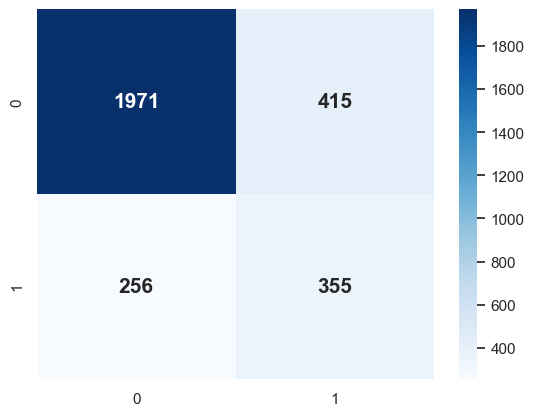

In [41]:
sns.heatmap(confusion_matrix(y_true= y_test, y_pred= y_pred_test_log), annot= True, fmt= "d", cmap= "Blues", annot_kws= {"size": 15, "weight": "bold"})
plt.show()


In [42]:
precision_score(y_true= y_test, y_pred= y_pred_test_log)


0.461038961038961

In [43]:
recall_score(y_true= y_test, y_pred= y_pred_test_log)


0.5810147299509002

In [44]:
print(classification_report(y_true= y_test, y_pred= y_pred_test_log))


              precision    recall  f1-score   support

           0       0.89      0.83      0.85      2386
           1       0.46      0.58      0.51       611

    accuracy                           0.78      2997
   macro avg       0.67      0.70      0.68      2997
weighted avg       0.80      0.78      0.79      2997



* `2. RandomForest`

In [45]:
## using RF -- with class weights
rf = RandomForestClassifier(n_estimators = 150, class_weight= weights, max_depth= 5, random_state= 42)
rf.fit(x_train_final, y_train)

## predict & evaluate
y_pred_train_rf = rf.predict(x_train_final)
y_pred_test_rf = rf.predict(x_test_final)


## using f1-score
score_train_rf = f1_score(y_train, y_pred_train_rf)
score_test_rf = f1_score(y_test, y_pred_test_rf)

print(f"f1-score for train: {score_train_rf}")
print(f"f1-score for test: {score_test_rf}")



f1-score for train: 0.6050654049540773
f1-score for test: 0.6041250831669993


In [46]:
## using RF -- with SMOTE
rf = RandomForestClassifier(n_estimators = 150, max_depth= 5, random_state= 42)
rf.fit(x_train_final_resampled, y_train_resampled)

## predict & evaluate
y_pred_train_rf = rf.predict(x_train_final)
y_pred_test_rf = rf.predict(x_test_final)

## using f1-score
score_train_rf = f1_score(y_train, y_pred_train_rf)
score_test_rf = f1_score(y_test, y_pred_test_rf)

print(f"f1-score for train: {score_train_rf}")
print(f"f1-score for test: {score_test_rf}")



f1-score for train: 0.6148229280759401
f1-score for test: 0.6292517006802721


* `RF tuning`

In [47]:
rf = RandomForestClassifier(n_estimators = 150, class_weight= weights, max_depth= 5, random_state= 42)

params_best_grid = {
    "n_estimators": np.arange(50, 400, 50),
    "max_depth": np.arange(2, 10, 2)
}

grid_search_forest = GridSearchCV(estimator= rf, param_grid= params_best_grid, cv= 5, verbose= 4, n_jobs= -1, scoring= "f1")
grid_search_forest.fit(X= x_train_final, y= y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 0.2038335002145616,
                                                            1: 0.7961664997854384},
                                              max_depth=5, n_estimators=150,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([2, 4, 6, 8]),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350])},
             scoring='f1', verbose=4)

In [48]:
## the best score according to your scoring metric & the best combination of parameters you search in
grid_search_forest.best_score_, grid_search_forest.best_params_


(0.6140549805285833, {'max_depth': 8, 'n_estimators': 200})

In [49]:
## the forest after tuning
forest_tuned = grid_search_forest.best_estimator_

## predict & evaluate
y_pred_train_forest_tuned = forest_tuned.predict(x_train_final)
y_pred_test_forest_tuned = forest_tuned.predict(x_test_final)

## using f1-score
score_train_forest_tuned = f1_score(y_train, y_pred_train_forest_tuned)
score_test_forest_tuned = f1_score(y_test, y_pred_test_forest_tuned)

print(f"f1-score for train: {score_train_forest_tuned}")
print(f"f1-score for test: {score_test_forest_tuned}")


f1-score for train: 0.706650093225606
f1-score for test: 0.6226834692364714


In [50]:
## download the model if you are satisfied with the results
joblib.dump(forest_tuned, os.path.join(MODELS_FOLDER_PATH, "forest_tuned.pkl"))


['d:\\courses\\AI courses\\mohamed agoor\\material\\churn_modelling_project\\notebooks\\..\\models\\forest_tuned.pkl']

In [51]:
forest_tuned.feature_importances_


array([0.0550319 , 0.35750517, 0.10335   , 0.05967957, 0.05150491,
       0.0078635 , 0.02476869, 0.0677772 , 0.00658988, 0.02964587,
       0.2362833 ])

In [52]:
features_after= [feature.split("__")[1] for feature in preprocessor.get_feature_names_out()]
features_after

['CreditScore',
 'Age',
 'Balance',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'IsActiveMember',
 'HasCrCard',
 'Tenure',
 'NumOfProducts']

In [53]:
## feature importance from RF
feature_importance = pd.DataFrame(data= {"feature": features_after,
                                         "importance": forest_tuned.feature_importances_}).sort_values(by= "importance", ascending= False)
feature_importance


,feature,importance
1,Age,0.357505
10,NumOfProducts,0.236283
2,Balance,0.103350
7,IsActiveMember,0.067777
3,EstimatedSalary,0.059680
0,CreditScore,0.055032
4,Geography_Germany,0.051505
9,Tenure,0.029646
6,Gender_Male,0.024769
5,Geography_Spain,0.007864


* `3. xgb`

In [76]:
## scale
scale = (y_train==0).sum() / (y_train==1).sum()

## compute class weights (to solve imbalanced data)
class_weights= compute_class_weight(
    class_weight= "balanced",
    classes= np.unique(y_train),
    y= y_train
)

class_weights = class_weights / np.sum(class_weights)

weights_dict= dict(zip(np.unique(y_train), class_weights))
weights_dict

sample_weights= np.array([weights_dict[y] for y in y_train])

In [97]:
xgb_clf = XGBClassifier(objective= "binary:logistic", n_estimators= 150, max_depth= 5, random_state= 42,
                        learning_rate= 0.1, scale_pos_weight= scale, reg_lambda= 8)

xgb_clf.fit(x_train_final, y_train)

## predict & evaluate
y_pred_train_xgb = xgb_clf.predict(x_train_final)
y_pred_test_xgb = xgb_clf.predict(x_test_final)

## using f1-score
score_train_xgb = f1_score(y_train, y_pred_train_xgb)
score_test_xgb = f1_score(y_test, y_pred_test_xgb)

print(f"f1-score for train: {score_train_xgb}")
print(f"f1-score for test: {score_test_xgb}")

f1-score for train: 0.698943661971831
f1-score for test: 0.620979020979021


In [100]:
params_best_grid = {
    "n_estimators": np.arange(50, 401, 50),
    "max_depth": np.arange(2, 10, 1),
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.05],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

randomized_search_xgb = RandomizedSearchCV(estimator= xgb_clf, param_distributions= params_best_grid, cv= 5, verbose= 4,
                                            n_jobs= -1, scoring= "f1", n_iter= 50, random_state=42)
randomized_search_xgb.fit(X= x_train_final, y= y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           predictor=None, random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.05],
                                        'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400]),
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   random_state=42, scoring='f1', verbose=4)

In [101]:
## the xgb after tuning
xgb_tuned= randomized_search_xgb.best_estimator_

## predict & evaluate
y_pred_train_xgb_tuned = xgb_tuned.predict(x_train_final)
y_pred_test_xgb_tuned = xgb_tuned.predict(x_test_final)

## using f1-score
score_train_xgb_tuned = f1_score(y_train, y_pred_train_xgb_tuned)
score_test_xgb_tuned = f1_score(y_test, y_pred_test_xgb_tuned)

print(f"f1-score for train: {score_train_xgb_tuned}")
print(f"f1-score for test: {score_test_xgb_tuned}")

f1-score for train: 0.860625
f1-score for test: 0.6310240963855421


In [102]:
## dump model
joblib.dump(xgb_tuned, os.path.join(MODELS_FOLDER_PATH, "xgb_tuned.pkl"))

['d:\\courses\\AI courses\\mohamed agoor\\material\\churn_modelling_project\\notebooks\\..\\models\\xgb_tuned.pkl']